# Data Loading and Preprocessing

In [3]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualization settings
sns.set_context("notebook", font_scale=1.5)

# Load the dataset
#file_path = 'C:/Users/pc/Desktop/politecnico/b-FINTECH/business cases/Fintech_BC/BC4/data/Dataset4_EWS.xlsx'
file_path = './data/Dataset4_EWS.xlsx'

## Real-World dataset

From Bloomberg, consisting of weekly observations of:

- Market and macroeconomic indicators (e.g., indices, rates).
- A response variable `Y` indicating **anomalous periods** (e.g., market stress events).

Data columns: ['Data', 'BDIY', 'CRY', 'Cl1', 'DXY', 'ECSURPUS', 'EMUSTRUU', 'EONIA', 'GBP', 'GT10', 'GTDEM10Y', 'GTDEM2Y', 'GTDEM30Y', 'GTGBP20Y', 'GTGBP2Y', 'GTGBP30Y', 'GTITL10YR', 'GTITL2YR', 'GTITL30YR', 'GTJPY10YR', 'GTJPY2YR', 'GTJPY30YR', 'JPY', 'LF94TRUU', 'LF98TRUU', 'LG30TRUU', 'LMBITR', 'LP01TREU', 'LUACTRUU', 'LUMSTRUU', 'MXBR', 'MXCN', 'MXEU', 'MXIN', 'MXJP', 'MXRU', 'MXUS', 'US0001M', 'USGG2YR', 'USGG30YR', 'USGG3M', 'VIX', 'XAUBGNL', 'Y']
Data shape: (1111, 42)
Total number of records: 1111
Time period: from 01/11/2000 to 04/20/2021
Frequency: W-TUE
Number of variables: 42
Number of anomalies: 237 (21.33%)

Metadata and statistics:


,Ticker,Description,Mean,Std.Dev,Min,Max,Missing values,Missing (%)
0,BDIY,Baltic Dry Index,2259.860486,2017.811888,291.00000,11793.00000,0,0.00%
1,CRY,TR/CC CRB ER Index,245.247649,68.278081,106.29290,467.57000,0,0.00%
2,Cl1,Generic 1st 'CL' Future,60.708101,25.900813,10.01000,140.97000,0,0.00%
3,DXY,DOLLAR INDEX SPOT,90.934982,11.379095,71.32900,119.82000,0,0.00%
4,ECSURPUS,Bloomberg ECO US Surprise Inde,0.036153,0.349453,-0.97400,0.99100,0,0.00%
5,EMUSTRUU,EM USD Aggregate,704.379495,309.951768,230.52670,1286.35300,0,0.00%
6,EONIA,EMMI EURO OverNight Index Aver,1.363676,1.721894,-0.49800,5.73000,0,0.00%
7,GBP,British Pound Spot,1.569618,0.212340,1.17230,2.08520,0,0.00%
8,GT10,US TREASURY N/B,3.266748,1.332464,0.50800,6.74800,0,0.00%
9,GTDEM10Y,BUNDESREPUB. DEUTSCHLAND,2.448365,1.851558,-0.79400,5.64400,0,0.00%


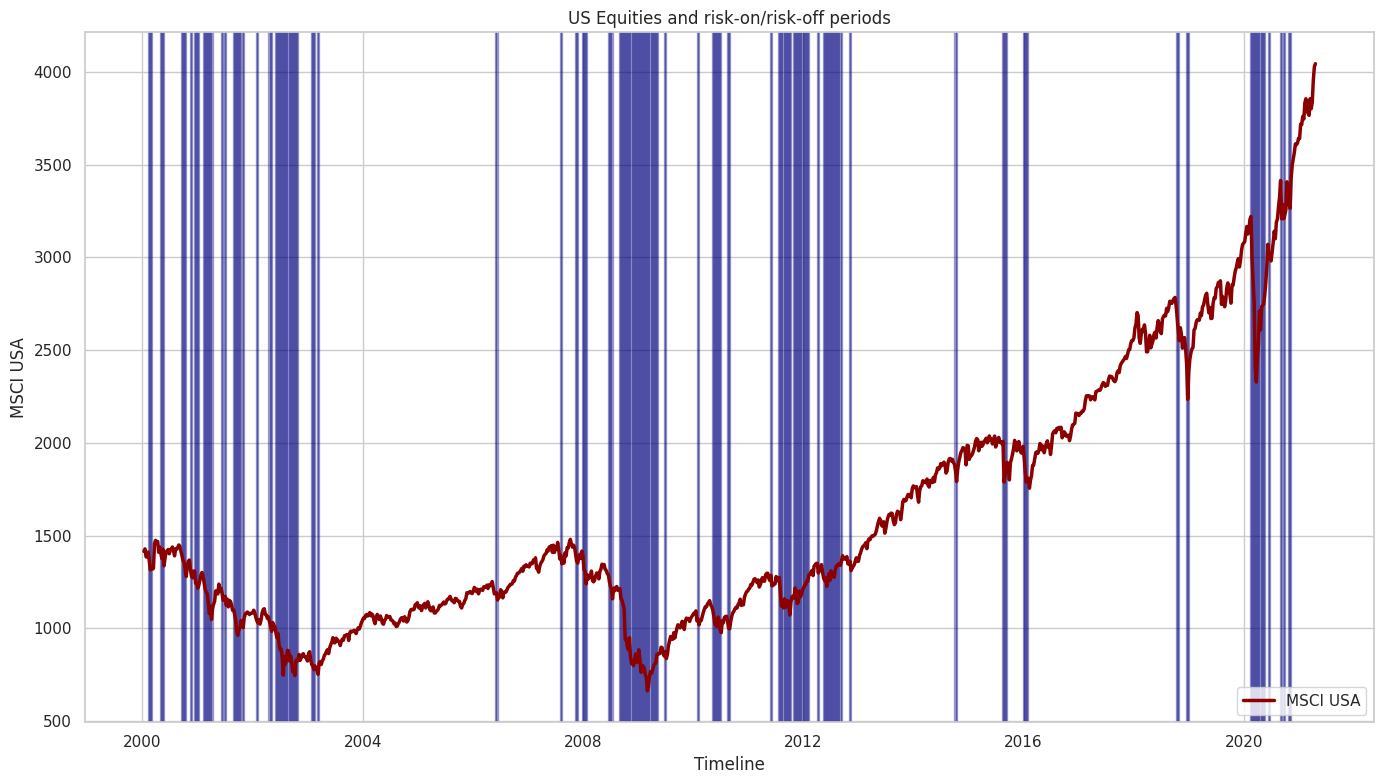

In [4]:
# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# Load the data from the Excel file
# First sheet contains market data with dates and anomaly labels, second sheet contains metadata
data_df = pd.read_excel(file_path, sheet_name='Markets')
metadata_df = pd.read_excel(file_path, sheet_name='Metadata')

# Check the structure of the loaded data
print("Data columns:", data_df.columns.tolist())

# Extract date and anomaly label columns
date_col = 'Date' if 'Date' in data_df.columns else data_df.columns[0]
y_col = 'Y' if 'Y' in data_df.columns else None

# Convert dates to datetime format
data_df[date_col] = pd.to_datetime(data_df[date_col], dayfirst=True)  # Date format is dd/mm/yy

# Set date as index
data_df = data_df.set_index(date_col)

# Extract features (all columns except Y if it exists)
if y_col:
    X_df = data_df.drop(y_col, axis=1)
    y = data_df[y_col].values
else:
    X_df = data_df
    y = None

# Display basic information about the dataset
print(f"Data shape: {X_df.shape}")
print(f"Total number of records: {len(X_df)}")
print(f"Time period: from {X_df.index.min().strftime('%m/%d/%Y')} to {X_df.index.max().strftime('%m/%d/%Y')}")
print(f"Frequency: {pd.infer_freq(X_df.index) or 'Weekly'}")
print(f"Number of variables: {X_df.shape[1]}")
if y_col:
    print(f"Number of anomalies: {np.sum(y == 1)} ({np.mean(y == 1)*100:.2f}%)")

# Create a more comprehensive metadata table with additional statistics
enhanced_metadata = []

# Determine the correct column names for ticker and description
ticker_col = 'ticker' if 'ticker' in metadata_df.columns else metadata_df.columns[0]
desc_col = 'description' if 'description' in metadata_df.columns else metadata_df.columns[1] if len(metadata_df.columns) > 1 else ticker_col

for ticker in X_df.columns:
    # Get metadata for this ticker if available
    meta_row = metadata_df[metadata_df[ticker_col] == ticker] if ticker in metadata_df[ticker_col].values else pd.DataFrame()

    # Get description or use ticker if not found
    description = meta_row[desc_col].values[0] if not meta_row.empty and desc_col in meta_row.columns else ticker

    # Calculate statistics for this series
    series = X_df[ticker]

    enhanced_metadata.append({
        'Ticker': ticker,
        'Description': description,
        'Mean': series.mean(),
        'Std.Dev': series.std(),
        'Min': series.min(),
        'Max': series.max(),
        'Missing values': series.isna().sum(),
        'Missing (%)': f"{series.isna().mean()*100:.2f}%"
    })

# Create enhanced metadata dataframe
enhanced_meta_df = pd.DataFrame(enhanced_metadata)

# Display the enhanced metadata
print("\nMetadata and statistics:")
display(enhanced_meta_df)

# Create a plot with anomalies as vertical bars and MXUS as a line
if y_col and 'MXUS' in X_df.columns:
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot MXUS line
    ax.plot(X_df.index, X_df['MXUS'], color='darkred', linewidth=2.5, label='MSCI USA')

    # Get the y-axis limits after plotting MXUS
    y_min, y_max = ax.get_ylim()

    # For each anomaly point (Y=1), create a vertical span across the entire plot
    for i, (date, is_anomaly) in enumerate(zip(X_df.index, y)):
        if is_anomaly == 1:
            ax.axvspan(date, date + pd.Timedelta(days=7), alpha=0.3, color='navy', label='Risk-on/Risk-off' if i == 0 else "")

    # Set labels and title
    ax.set_xlabel('Timeline')
    ax.set_ylabel('MSCI USA')
    ax.set_title('US Equities and risk-on/risk-off periods')

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='best')

    plt.tight_layout()
    plt.show()
else:
    print("Either 'Y' column or 'MXUS' column is missing in the dataset.")


# LSTM model

# Model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class LSTMTimeSeriesClassifier:
    """
    An improved LSTM-based time series classifier with enhanced training and evaluation.
    """
    
    def __init__(self, sequence_length=10, n_features=1, scaler_type='standard'):
        """
        Initialize the classifier.
        
        Parameters:
        -----------
        sequence_length : int
            The number of time steps in each input sequence.
        n_features : int
            The number of features at each time step.
        scaler_type : str
            Type of scaler to use ('standard' or 'minmax')
        """
        self.sequence_length = sequence_length
        self.n_features = n_features
        self.model = None
        
        # Choose the appropriate scaler
        if scaler_type.lower() == 'standard':
            self.scaler = StandardScaler()
        elif scaler_type.lower() == 'minmax':
            self.scaler = MinMaxScaler()
        else:
            raise ValueError("scaler_type must be 'standard' or 'minmax'")
            
        self.history = None
        self.class_weights = None
        
    def build_model(self, n_classes, lstm_units_list=[100, 50], dropout_rate=0.3, 
                   learning_rate=0.001, bidirectional=True, l1_reg=0.0, l2_reg=0.001,
                   kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal'):
        """
        Build an improved LSTM model architecture with proper weights initialization.
        
        Parameters:
        -----------
        n_classes : int
            The number of output classes.
        lstm_units_list : list of int
            Number of units for each LSTM layer.
        dropout_rate : float
            Dropout rate to prevent overfitting.
        learning_rate : float
            Learning rate for the Adam optimizer.
        bidirectional : bool
            Whether to use bidirectional LSTM layers.
        l1_reg : float
            L1 regularization factor.
        l2_reg : float
            L2 regularization factor.
        kernel_initializer : str
            Initializer for the kernel weights matrix (default: 'glorot_uniform').
            Options: 'glorot_uniform', 'he_uniform', 'he_normal', etc.
        recurrent_initializer : str
            Initializer for the recurrent weights matrix (default: 'orthogonal').
            Options: 'orthogonal', 'glorot_uniform', 'he_normal', etc.
        """
        model = Sequential()
        
        # Regularization settings
        reg = l1_l2(l1=l1_reg, l2=l2_reg)
        
        for i, units in enumerate(lstm_units_list):
            return_sequences = i < len(lstm_units_list)-1  # True except for last layer
            
            # First layer needs input shape
            if i == 0:
                if bidirectional:
                    model.add(Bidirectional(
                        LSTM(units, activation='tanh', return_sequences=return_sequences,
                            kernel_regularizer=reg, recurrent_regularizer=reg,
                            kernel_initializer=kernel_initializer,
                            recurrent_initializer=recurrent_initializer,
                            bias_initializer='zeros'),
                        input_shape=(self.sequence_length, self.n_features)
                    ))
                else:
                    model.add(LSTM(
                        units, activation='tanh', return_sequences=return_sequences,
                        kernel_regularizer=reg, recurrent_regularizer=reg,
                        kernel_initializer=kernel_initializer,
                        recurrent_initializer=recurrent_initializer,
                        bias_initializer='zeros',
                        input_shape=(self.sequence_length, self.n_features)
                    ))
            else:
                if bidirectional:
                    model.add(Bidirectional(
                        LSTM(units, activation='tanh', return_sequences=return_sequences,
                            kernel_regularizer=reg, recurrent_regularizer=reg,
                            kernel_initializer=kernel_initializer,
                            recurrent_initializer=recurrent_initializer,
                            bias_initializer='zeros')
                    ))
                else:
                    model.add(LSTM(
                        units, activation='tanh', return_sequences=return_sequences,
                        kernel_regularizer=reg, recurrent_regularizer=reg,
                        kernel_initializer=kernel_initializer,
                        recurrent_initializer=recurrent_initializer,
                        bias_initializer='zeros'
                    ))
            
            # Add batch normalization and dropout after each LSTM layer
            model.add(BatchNormalization(
                beta_initializer='zeros',
                gamma_initializer='ones',
                moving_mean_initializer='zeros',
                moving_variance_initializer='ones'
            ))
            model.add(Dropout(dropout_rate))
        
        # Add a dense hidden layer with batch normalization
        model.add(Dense(32, activation='relu', 
                      kernel_regularizer=reg,
                      kernel_initializer='he_uniform',  # He initialization is better for ReLU
                      bias_initializer='zeros'))
        model.add(BatchNormalization(
            beta_initializer='zeros',
            gamma_initializer='ones',
            moving_mean_initializer='zeros',
            moving_variance_initializer='ones'
        ))
        model.add(Dropout(dropout_rate/2))  # Reduced dropout for final layers
        
        # Output layer
        model.add(Dense(n_classes, activation='softmax',
                      kernel_initializer='glorot_uniform',  # Glorot/Xavier is good for softmax
                      bias_initializer='zeros'))
        
        # Use Adam optimizer with customizable learning rate
        optimizer = Adam(learning_rate=learning_rate)
        
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def prepare_sequences(self, data, labels=None, stride=1):
        """
        Prepare time series data into overlapping sequences.
        
        Parameters:
        -----------
        data : array-like
            Time series data of shape (n_samples, n_features).
        labels : array-like, optional
            Class labels for each time step.
        stride : int
            Step size between consecutive sequences (default: 1).
            
        Returns:
        --------
        X : numpy.ndarray
            Sequence data of shape (n_sequences, sequence_length, n_features).
        y : numpy.ndarray or None
            Labels for each sequence if labels are provided.
        """
        # Ensure data is a numpy array
        data = np.array(data)
        
        # Check if the data has the right shape
        if len(data.shape) == 1:
            # Convert 1D array to 2D with single feature
            data = data.reshape(-1, 1)
        
        n_samples, n_features = data.shape
        self.n_features = n_features
        
        X = []
        y = []
        
        # Make sure we have enough data points to create at least one sequence
        if n_samples <= self.sequence_length:
            print(f"Warning: Not enough samples ({n_samples}) for the given sequence length ({self.sequence_length}). Returning empty arrays.")
            return np.array(X), np.array(y)
        
        # Use stride to control overlap between sequences
        for i in range(0, n_samples - self.sequence_length, stride):
            X.append(data[i:i + self.sequence_length])
            if labels is not None:
                # Use the label at the end of the sequence
                y.append(labels[i + self.sequence_length - 1])
        
        X = np.array(X)
        
        if labels is not None:
            y = np.array(y)
            return X, y
        
        return X
    
    def compute_class_weights(self, y):
        """
        Compute class weights for imbalanced datasets.
        
        Parameters:
        -----------
        y : array-like
            Class labels.
            
        Returns:
        --------
        class_weights : dict
            Dictionary mapping class indices to weights.
        """
        # Count number of samples in each class
        unique_classes = np.unique(y)
        class_counts = np.bincount(y)
        
        # Compute weights inversely proportional to class frequencies
        total_samples = len(y)
        n_classes = len(unique_classes)
        
        # Class weight calculation
        class_weights = {}
        for cls in unique_classes:
            # Calculate weight as inverse of frequency, normalized
            class_weights[cls] = total_samples / (n_classes * class_counts[cls])
            
        return class_weights
    
    def fit(self, X, y, epochs=1000, batch_size=32, validation_split=0.2, 
            verbose=1, use_class_weights=True, stride=1, learning_rate=0.001,
            bidirectional=True, l1_reg=0.0, l2_reg=0.001,
            kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal'):
        """
        Train the LSTM model with improved training parameters.
        
        Parameters:
        -----------
        X : array-like
            Time series data of shape (n_samples, n_features).
        y : array-like
            Class labels for each time step.
        epochs : int
            Number of training epochs.
        batch_size : int
            Batch size for training.
        validation_split : float
            Fraction of training data to use for validation.
        verbose : int
            Verbosity mode (0, 1, or 2).
        use_class_weights : bool
            Whether to use class weights for imbalanced datasets.
        stride : int
            Stride for sequence preparation (controls data augmentation).
        learning_rate : float
            Initial learning rate for the optimizer.
        bidirectional : bool
            Whether to use bidirectional LSTM layers.
        l1_reg : float
            L1 regularization factor.
        l2_reg : float
            L2 regularization factor.
        augment_data : bool
            Whether to apply time series data augmentation.
        kernel_initializer : str
            Initializer for the kernel weights matrix.
        recurrent_initializer : str
            Initializer for the recurrent weights matrix.
            
        Returns:
        --------
        self : LSTMTimeSeriesClassifier
            The fitted classifier.
        """
        # Convert inputs to numpy arrays if they're not already
        X = np.array(X)
        y = np.array(y)
        
        # If X is a DataFrame, convert to numpy array
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        # Handle 1D arrays
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        
        # Scale the features
        X_scaled = self.scaler.fit_transform(X)
        
        # Get number of unique classes
        unique_classes = np.unique(y)
        n_classes = len(unique_classes)
        print(f"Number of classes detected: {n_classes}")
        
        # Print class distribution
        class_counts = np.bincount(y)
        for cls in unique_classes:
            print(f"Class {cls}: {class_counts[cls]} samples ({class_counts[cls]/len(y):.2%})")
        
        # Compute class weights if requested and if class imbalance exists
        if use_class_weights:
            self.class_weights = self.compute_class_weights(y)
            print("Using class weights:", self.class_weights)
        else:
            self.class_weights = None
        
        # Prepare sequences
        try:
            X_seq, y_seq = self.prepare_sequences(X_scaled, y, stride=stride)
            print(f"Prepared sequences: X shape = {X_seq.shape}, y shape = {y_seq.shape}")
        except Exception as e:
            print(f"Error preparing sequences: {e}")
            raise
        
        # Build the model if not already built
        if self.model is None:
            self.model = self.build_model(
                n_classes=n_classes,
                learning_rate=learning_rate,
                bidirectional=bidirectional,
                l1_reg=l1_reg,
                l2_reg=l2_reg,
                kernel_initializer=kernel_initializer,
                recurrent_initializer=recurrent_initializer
            )
            print(f"Model built with {n_classes} output classes")
            
        # Print model summary
        self.model.summary()
        
        # Add callbacks for better training
        callbacks = [
            # Early stopping to prevent overfitting
            EarlyStopping(
                monitor='val_loss',
                patience=10,  # Increased patience
                restore_best_weights=True,
                verbose=1
            ),
            # Learning rate reduction on plateau
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6,
                verbose=1
            )
        ]
        
        # Train the model
        try:
            self.history = self.model.fit(
                X_seq, y_seq,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=validation_split,
                callbacks=callbacks,
                verbose=verbose,
                class_weight=self.class_weights
            )
            
            # Display training results
            best_val_acc = max(self.history.history['val_accuracy'])
            best_epoch = np.argmax(self.history.history['val_accuracy']) + 1
            print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
            
        except Exception as e:
            print(f"Error during model training: {e}")
            print(f"X_seq shape: {X_seq.shape}")
            print(f"y_seq shape: {y_seq.shape}")
            raise
        
        return self
        
    def predict(self, X, return_probabilities=False):
        """
        Make predictions on new data.
        
        Parameters:
        -----------
        X : array-like
            Time series data of shape (n_samples, n_features).
        return_probabilities : bool
            Whether to return class probabilities instead of class predictions.
            
        Returns:
        --------
        y_pred : numpy.ndarray
            Predicted class labels or probabilities.
        """
        # Convert to numpy array if needed
        X = np.array(X)
        
        # Handle 1D arrays
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
            
        # Scale the features
        X_scaled = self.scaler.transform(X)
        
        # Prepare sequences
        X_seq = self.prepare_sequences(X_scaled)
        
        # Make predictions
        y_pred_proba = self.model.predict(X_seq)
        
        if return_probabilities:
            return y_pred_proba
        else:
            y_pred = np.argmax(y_pred_proba, axis=1)
            return y_pred
    
    def evaluate(self, X, y, threshold=None, average='weighted'):
        """
        Evaluate the model on test data.
        
        Parameters:
        -----------
        X : array-like
            Time series data of shape (n_samples, n_features).
        y : array-like
            Class labels for each time step.
        threshold : float, optional
            Decision threshold for binary classification.
        average : str
            The type of averaging to use for multi-class metrics ('micro', 'macro', 'weighted').
            
        Returns:
        --------
        metrics : dict
            Dictionary of evaluation metrics.
        """
        # Convert to numpy arrays
        X = np.array(X)
        y = np.array(y)
        
        # Handle 1D arrays
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
            
        # Scale the features
        X_scaled = self.scaler.transform(X)
        
        # Prepare sequences
        X_seq, y_seq = self.prepare_sequences(X_scaled, y)
        
        # Check if we're dealing with binary classification
        is_binary = len(np.unique(y_seq)) == 2
        
        # Make predictions
        y_pred_proba = self.model.predict(X_seq)
        
        if is_binary and threshold is not None:
            # Binary classification with custom threshold
            y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)
        else:
            # Default: argmax for multi-class or standard binary
            y_pred = np.argmax(y_pred_proba, axis=1)
            
        # Evaluate the model
        loss, accuracy = self.model.evaluate(X_seq, y_seq, verbose=0)
        
        # Compute metrics
        metrics = {
            'accuracy': accuracy_score(y_seq, y_pred),
            'precision': precision_score(y_seq, y_pred, average=average, zero_division=0),
            'recall': recall_score(y_seq, y_pred, average=average, zero_division=0),
            'f1': f1_score(y_seq, y_pred, average=average, zero_division=0)
        }
        
        # Print classification report
        print(metrics)
        
        # Print confusion matrix
        print("\nConfusion Matrix:")
        cm = confusion_matrix(y_seq, y_pred)
        print(cm)
        
                
        return metrics, y_pred      

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize and train the classifier
sequence_length = 40
classifier = LSTMTimeSeriesClassifier(sequence_length=sequence_length)

classifier.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    use_class_weights=True,
    bidirectional=True,
    l2_reg=0.01
)

# Evaluate the model
metrics, y_pred = classifier.evaluate(X_test, y_test)
